<a href="https://colab.research.google.com/github/PedroAdair/TesisMaestria/blob/main/Anonimizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Instalación de paqueterias importantes

In [2]:
#@title gower (0.1.2)
!pip install gower 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#@title networkx
!pip install networkx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#@title Igraph (1.6.7)
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.2 MB/s eta 0:00:00


In [6]:
import gower
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import networkx as nx

#1. Construcción del grafo

La primer tarea consiste en construir un grafo a partir de la base de datos que se tiene previemente, como nuestros registros contienen observaciones numericas y categoricas, se opta por usar el coeficiente de similitud de Gower.

In [ ]:
#link donde se encuentra la base de datos
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# leer el archivo CSV de la base de datos adult
df = pd.read_csv(url, header=None)

In [ ]:
#Para estos primeros resultados, solo trabajare con n=100
n = 100
df  = df.head(n)

In [ ]:
matriz_distancias = gower.gower_matrix(df)
matriz_distancias

array([[0.        , 0.31261942, 0.31625032, ..., 0.45070857, 0.503844  ,
        0.39384323],
       [0.31261942, 0.        , 0.4071618 , ..., 0.34162003, 0.44175005,
        0.4847547 ],
       [0.31625032, 0.4071618 , 0.        , ..., 0.34806943, 0.36541176,
        0.3442596 ],
       ...,
       [0.45070857, 0.34162003, 0.34806943, ..., 0.        , 0.49986997,
        0.49014324],
       [0.503844  , 0.44175005, 0.36541176, ..., 0.49986997, 0.        ,
        0.576338  ],
       [0.39384323, 0.4847547 , 0.3442596 , ..., 0.49014324, 0.576338  ,
        0.        ]], dtype=float32)

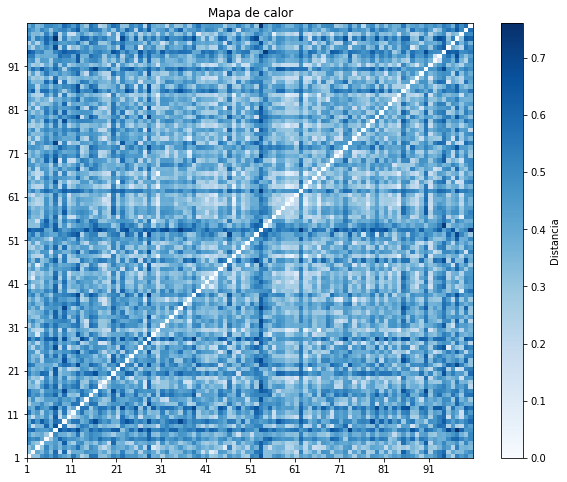

In [ ]:
def generar_mapa_calor(matriz):
    # Creamos la figura y el eje
    fig, ax = plt.subplots(figsize=(10, 8))

    # Generamos el mapa de calor a partir de la matriz
    heatmap = ax.pcolor(matriz, cmap=plt.cm.Blues)

    # Configuramos los ticks de los ejes x e y
    xticks = np.arange(0, matriz.shape[1], 10)
    yticks = np.arange(0, matriz.shape[0], 10)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # Agregamos las etiquetas correspondientes a los ticks de los ejes x e y
    ax.set_xticklabels(np.arange(1, matriz.shape[1]+1, 10))
    ax.set_yticklabels(np.arange(1, matriz.shape[0]+1, 10))

    # Agregamos una barra de color para indicar la escala de valores
    barra_color = plt.colorbar(heatmap)
    barra_color.set_label('Distancia')

    # Agregamos un título al mapa de calor
    ax.set_title('Mapa de calor')

    # Mostramos el mapa de calor generado
    plt.show()

# Ejemplo de uso
generar_mapa_calor(matriz_distancias)

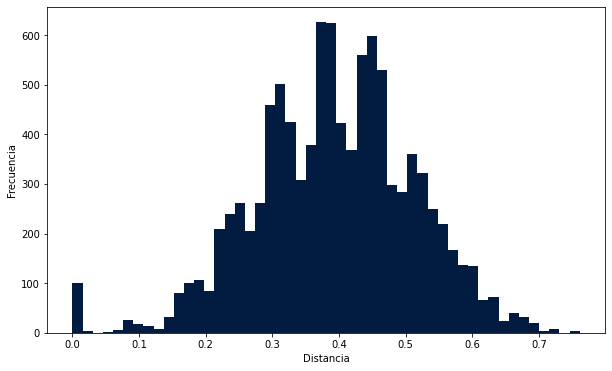

In [ ]:
bar_color = (1/255, 28/255, 64/255)  # Normalizar los valores RGB de 0-255 a 0-1  
flat_matriz_distancias = matriz_distancias.flatten()
plt.figure(figsize=(10, 6))
plt.hist(flat_matriz_distancias,bins=50, color=bar_color)
#plt.title('Distancias de Gower sobre el conjunto "Adult"')
plt.xlabel('Distancia')
plt.ylabel('Frecuencia')
plt.show()

Surge aqui un nuevo reto: ¿a partir de que umbral definimos que 2 registros (vértices) tienen una arista en común? 

Creamos un grafo totalmente conectado con $n=100$ vértices y vamos eliminando aquellas aristas que corresponden a los elementos con distancias mayores que obtuvimos en la amtriz de Gower hasta alcanzar una eficiencia global de 0.8.

In [ ]:
#Crea el grafo completo
g = nx.complete_graph(n)
# Obtener umbral correspondiente al percentil 80 de las distancias
threshold = np.percentile(np.sort(matriz_distancias.flatten())[::-1], 60)
print(f"threshold: {threshold}")
# Calcular eficiencia global inicial
efficiency = nx.algorithms.global_efficiency(g)
print(f"Eficiencia inicial: {efficiency}")

threshold: 0.43060379028320306
Eficiencia inicial: 1.0


In [ ]:
# Eliminar aristas cuya distancia sea mayor que el umbral
for u, v in g.edges():
    if matriz_distancias[u][v] > threshold:
        #print(matriz_distancias[u][v])
        g.remove_edge(u, v)

# Calcular eficiencia global
efficiency = nx.algorithms.global_efficiency(g)
# Imprimir la eficiencia global final
print(f"La eficiencia global alcanzada fue de: {efficiency}")

La eficiencia global alcanzada fue de: 0.797407407407407


Finalmente, podemos dibujar el grafo obtenido

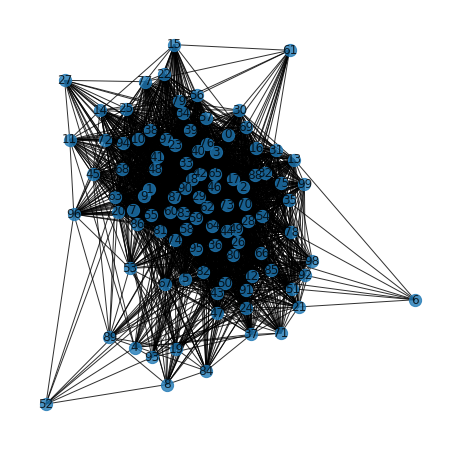

In [ ]:
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g, seed=2023) 
nx.draw_networkx(g, pos=pos, with_labels=True, node_size=150, alpha=0.8, edge_color='k')

plt.axis('off')
plt.show()

In [ ]:
# Obtener número de vértices y aristas
print("Número de vértices:", nx.number_of_nodes(g))
print("Número de aristas:", nx.number_of_edges(g))

Número de vértices: 100
Número de aristas: 2950


Considerando que un grafo totalmento conectado con 100  nodos tiene un total de 4950 aristas, hemos obtenido un grafo que tiene una eficiencia global de 0.8 con 2,000 conecciones menos.

#2. Detección de comunidades

In [ ]:
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

El primer paso antes de aplicar la detección de comunidades, es el de pasar nuestro grafo de networkx a igraph

In [ ]:
g = nx.karate_club_graph()

In [ ]:
G = ig.Graph.from_networkx(g)

A continuación aplicamos 5 métodos para la detección de comunidades, cada uno de ellos posee diferentes caracteristicas que le otorgan una serie de ventajas y desventajas, nuestro objetivo es analizarlos en la tarea de detección de comunidades, los algoritmos son los siguientes:
* Algoritmo de Louvain  `community_multilevel`
* Algoritmo de Infomap `community_infomap`
* Algoritmo de Propagación de la etiqueta  `community_label_propagation`
* Algoritmo de minimización de la energía `community_spinglass` 



##2.1 Algoritmo de Louvain  `community_multilevel`



In [ ]:
# Aplicar el algoritmo de Louvain
Louvain = G.community_multilevel()

# Imprimir la partición del grafo en comunidades
print(Louvain)

Clustering with 34 elements and 4 clusters
[0] 0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21
[1] 4, 5, 6, 10, 16
[2] 8, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33
[3] 24, 25, 28, 31


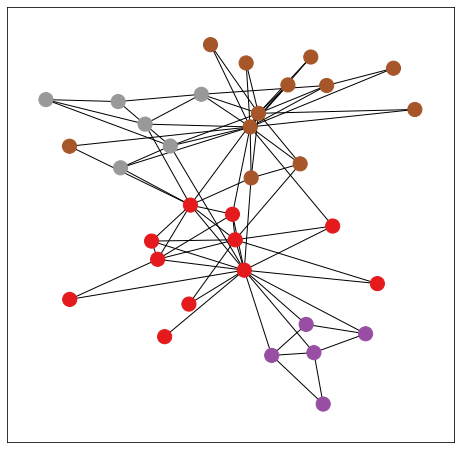

In [ ]:
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g, seed=2023)
nx.draw_networkx_nodes(g, pos, node_size=200, cmap=plt.cm.Set1, node_color=Louvain.membership)
nx.draw_networkx_edges(g, pos)
plt.show()

##2.2  Algoritmo de Infomap `community_infomap`

In [ ]:
# Aplicar el algoritmo de Infomap
Infomap = G.community_infomap()

# Imprimir la partición del grafo en comunidades
print(Infomap)

Clustering with 34 elements and 3 clusters
[0] 0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21
[1] 4, 5, 6, 10, 16
[2] 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33


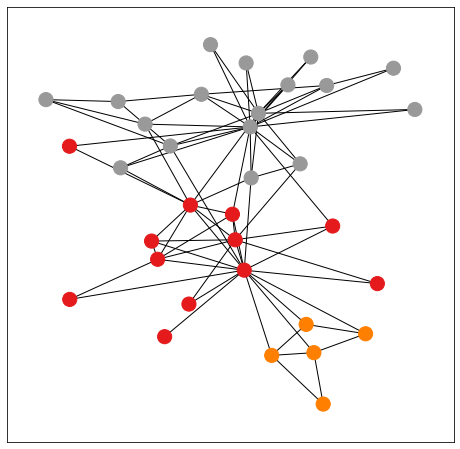

In [ ]:
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g, seed=2023)
nx.draw_networkx_nodes(g, pos, node_size=200, cmap=plt.cm.Set1, node_color=Infomap.membership)
nx.draw_networkx_edges(g, pos)
plt.show()

##2.3 Algoritmo de Propagación de la etiqueta  `community_label_propagation`

In [ ]:
# Aplicar el algoritmo de Propagación de  etiqueta
label_propagation = G.community_label_propagation()
walktrap = label_propagation
# Imprimir la partición del grafo en comunidades
print(label_propagation)

Clustering with 34 elements and 3 clusters
[0] 0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21
[1] 4, 5, 6, 10, 16
[2] 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33


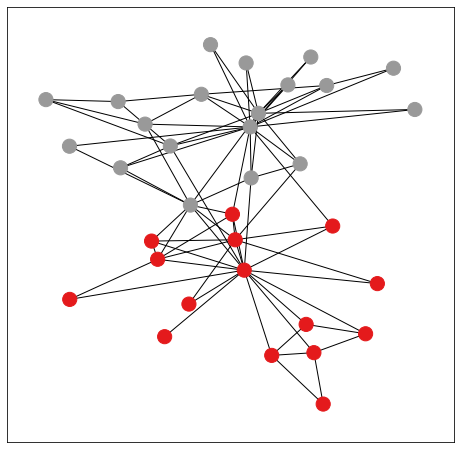

In [ ]:
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g, seed=2023)
nx.draw_networkx_nodes(g, pos, node_size=200, cmap=plt.cm.Set1, node_color=label_propagation.membership)
nx.draw_networkx_edges(g, pos)
plt.show()

##2.4 Algoritmo de minimización de la energía `community_spinglass` 

---



In [ ]:
# Aplicar el algoritmo de  
spinglass = G.community_spinglass()

# Imprimir la partición del grafo en comunidades
print(spinglass)

Clustering with 34 elements and 4 clusters
[0] 23, 24, 25, 27, 28, 31
[1] 0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21
[2] 8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33
[3] 4, 5, 6, 10, 16


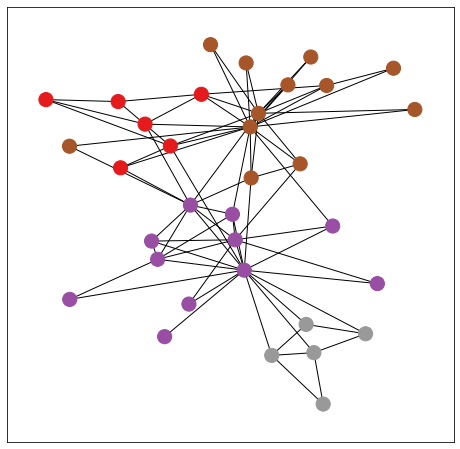

In [ ]:
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g, seed=2023)

nx.draw_networkx_nodes(g, pos, node_size=200, cmap=plt.cm.Set1, node_color=spinglass.membership)
nx.draw_networkx_edges(g, pos)
plt.show()

##2.5 walktrap

In [ ]:
# Aplicar el algoritmo de Walktrap y obtener la partición en comunidades
clustering = G.community_walktrap().as_clustering()

# Obtener la pertenencia de cada nodo a cada comunidad
membership = clustering.membership
print(membership)

[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 2, 0, 0, 1, 3, 3, 2, 0, 3, 0, 3, 0, 3, 4, 4, 4, 3, 4, 1, 3, 1, 1, 3, 3]


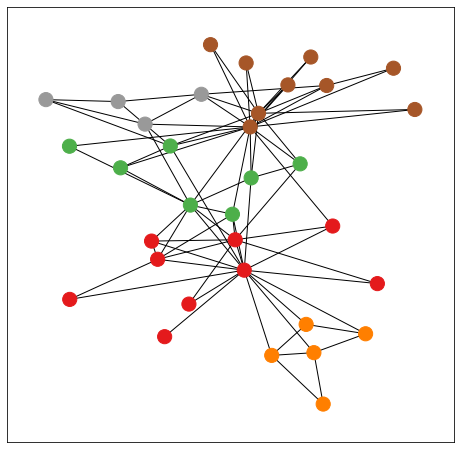

In [ ]:
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g, seed=2023)

nx.draw_networkx_nodes(g, pos, node_size=200, cmap=plt.cm.Set1, node_color=membership)
nx.draw_networkx_edges(g, pos)
plt.show()

#3. Comparación de comunidades

In [7]:
from sklearn.metrics.cluster import adjusted_rand_score, rand_score
from sklearn.metrics import jaccard_score
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image

##3.1 Karate Club

In [9]:
karate = ig.Graph.Famous('Zachary')

In [10]:
print(karate)

IGRAPH U--- 34 78 --
+ edges:
 0 --  1  2  3  4  5  6  7  8 10 11 12 13 17 19 21 31      25 -- 23 24 31
 1 --  0  2  3  7 13 17 19 21 30                           26 -- 29 33
 2 --  0  1  3  7  8  9 13 27 28 32                        27 --  2 23 24 33
 3 --  0  1  2  7 12 13                                    28 --  2 31 33
 4 --  0  6 10                                             29 -- 23 26 32 33
 5 --  0  6 10 16                                          30 --  1  8 32 33
 6 --  0  4  5 16                                          31 --  0 24 25 28
32 33
 7 --  0  1  2  3                                          32 --  2  8 14 15
18 20 22 23 29 30 31 33
 8 --  0  2 30 32 33                                       33 --  8  9 13 14
15 18 19 20 22 23 26 27 28 29 30 31 32
 9 --  2 33
10 --  0  4  5
11 --  0
12 --  0  3
13 --  0  1  2  3 33
14 -- 32 33
15 -- 32 33
16 --  5  6
17 --  0  1
18 -- 32 33
19 --  0  1 33
20 -- 32 33
21 --  0  1
22 -- 32 33
23 -- 25 27 29 32 33
24 -- 25 27 31


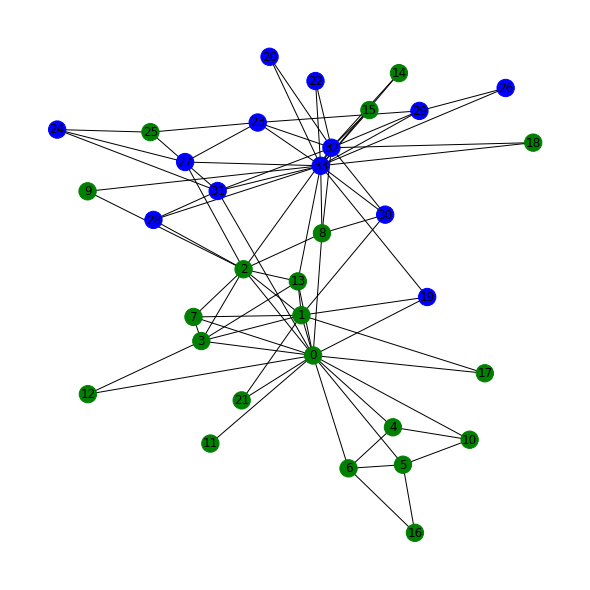

In [11]:
plt.figure(figsize=(8, 8))
# Cargar el grafo del club de karate de Zachary
g = nx.karate_club_graph()

# Obtener las coordenadas de los nodos con spring_layout
pos = nx.spring_layout(g, seed=2023)

# Definir la afiliación a las comunidades
comunidades = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
    1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
    1, 1, 1, 1]

# Crear un diccionario para mapear las comunidades a colores
colores = {0: 'g', 1: 'b'}
color_map = [colores[comunidades[i]] for i in range(len(comunidades))]

# Dibujar el grafo con las comunidades coloreadas
nx.draw(g, pos, node_color=color_map, with_labels=True)
plt.show()

###3.1.1 Comparación de karate

In [21]:
comunidades = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
    1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
    1, 1, 1, 1]
G_karate = ig.Graph.from_networkx(g)

In [36]:
louvain = G_karate.community_multilevel()
infomap = G_karate.community_infomap()
label_propagation = G_karate.community_label_propagation()
spinglass = G_karate.community_spinglass()
# Aplicar el algoritmo de Walktrap y obtener la partición en comunidades
walktrap = G_karate.community_walktrap().as_clustering()

A continuación se realiza la evaluación de las comunidades encontradas por los diferentes métodos bajo el indice Rand , Rand ajustado y Jacard.

In [41]:
#@title Rand Score
rand_score_louvain    = rand_score(comunidades,louvain.membership)
rand_score_infomap    = rand_score(comunidades,infomap.membership)
rand_score_label_prop =  rand_score(comunidades,label_propagation.membership)
rand_score_spinglass  =  rand_score(comunidades,spinglass.membership)
rand_score_walktrap   = rand_score(comunidades,walktrap.membership)

In [42]:
rand_scores = [rand_score_louvain,
               rand_score_infomap,
               rand_score_label_prop,
               rand_score_spinglass,
               rand_score_walktrap]

In [40]:
#@title Adjusted Rand Score
adjusted_rand_score_louvain    = adjusted_rand_score(comunidades,louvain.membership)
adjusted_rand_score_infomap    = adjusted_rand_score(comunidades,infomap.membership)
adjusted_rand_score_label_prop =  adjusted_rand_score(comunidades,label_propagation.membership)
adjusted_rand_score_spinglass  =  adjusted_rand_score(comunidades,spinglass.membership)
adjusted_rand_score_walktrap   = adjusted_rand_score(comunidades,walktrap.membership)

In [43]:
adjusted_rand_scores = [adjusted_rand_score_louvain,
                        adjusted_rand_score_infomap,
                        adjusted_rand_score_label_prop,
                        adjusted_rand_score_spinglass,
                        adjusted_rand_score_walktrap]

In [39]:
#@title Jaccard Score
jaccard_score_louvain    = jaccard_score(comunidades,louvain.membership,average='macro')
jaccard_score_infomap    = jaccard_score(comunidades,infomap.membership,average='macro')
jaccard_score_label_prop =  jaccard_score(comunidades,label_propagation.membership,average='macro')
jaccard_score_spinglass  =  jaccard_score(comunidades,spinglass.membership,average='macro')
jaccard_score_walktrap   = jaccard_score(comunidades,walktrap.membership,average='macro')

In [44]:
jaccard_scores =[jaccard_score_louvain,
                 jaccard_score_infomap,
                 jaccard_score_label_prop,
                 jaccard_score_spinglass,
                 jaccard_score_walktrap]

###3.1.2 Resultados
Los resultados se muestran en la siguiente tabla.

##3.2 Redes sinteticas

A continuación una lista donde enumero los algoritmos para la detección de comunidades que estan implementados en la función `compare_communities()`, recibe como entrada un grafo y 2 numeros correspondientes a los siguientes métodos, devuele el índice Rand ajustado entre las comunidades detectadas por ambos métodos.
* 0. La partición real. 
* 1. `community_multilevel() `
* 2. `community_infomap() `
* 3. `community_label_propagation() `
* 4. `community_spinglass() `
* 5. `community_walktrap() `
Por otra parte, la metrica es el ultimo parametro.
* 1.  adjusted_rand_score
* 2.   rand_score
* 3.  jaccard_score

In [ ]:
compare_communities(karate,0,3,3)

0.6566985645933014

In [ ]:
def compare_communities(graph, method1, method2, metric):
    """
    Calcula el índice Rand entre dos detecciones de comunidades en un grafo.

    Parameters:
    -----------
    graph : igraph.Graph
        Un objeto de grafo de igraph.
    method1 : str
        El nombre de un método de detección de comunidades de igraph, por ejemplo "community_fastgreedy".
    method2 : str
        El nombre de otro método de detección de comunidades de igraph.
    metric: int
        El numero asociado al metodo que compara
    Returns:
    --------
    float
        El índice Rand entre las detecciones de comunidades utilizando los dos métodos.
    """
    if method1 == 0:
      c1 = comunidades
    elif method1 == 1:
      # Realizar la detección de comunidades del primer método
      c1 = graph.community_multilevel().membership
    elif method1 == 2:
      #community_infomap
      c1 = graph.community_infomap().membership
    elif method1 == 3:
      #community_label_propagation
      c1 = graph.community_label_propagation().membership
    elif method1 == 4:
      #community_spinglass
      c1 = graph.community_spinglass().membership
    else:
      #community_walktrap
      walktrap_dendrogram = graph.community_walktrap()
      c1 = walktrap_dendrogram.as_clustering().membership
    """
   -----------------------------------------------------------------------
    """
    if method2 == 0:
      c2 = comunidades
    elif method2 == 1:
      # Realizar la detección de comunidades utilizando los dos métodos
      c2 = graph.community_multilevel().membership
    elif method2 == 2:
      #community_infomap
      c2 = graph.community_infomap().membership
    elif method2 == 3:
      #community_label_propagation
      c2 = graph.community_label_propagation().membership
    elif method2 == 4:
      #community_spinglass
      c2 = graph.community_spinglass().membership
    else:
      #community_walktrap
      walktrap_dendrogram = graph.community_walktrap()
      c2 = walktrap_dendrogram.as_clustering().membership
    # Calcular el índice Rand entre las detecciones de comunidades
    if metric == 1:
      index =  adjusted_rand_score(c1, c2)
    elif metric == 2:
      index = rand_score(c1, c2)
    else:
      index =  jaccard_score(c1, c2, average='macro')

    return index

##3.2 Ejemplos sinteticos

El primer paso consiste en construir de manera artificial un grafo con comunidades. Para ello, con la función `crear_matrices_adyacencia` se parte de una lista y genera tantas comunidades como la longitud de la lista, y cada una de ellas del tamaño indicado en la $j$-esima componente.

Posteriormente se trabajan estas matrices para cosntruir una matriz por bloques donde agregamos conecciones entre los vertices de la red de manera aleatoria con una función bonomial con una  probabilidad $p$.

 Esto produce una matriz de adyacencia con la cual la función `from_matrix_to_Grahp` construye y muestra la red obtenida con ayuda de `pinta_comunidades`

In [ ]:
#@title Redes sinteticas
import numpy as np

#La primer etapa consiste en crear los "bloques" en las matrices de adyacencia que corresponen a las comunidades,
#las conecciones se realizan basados en una distribución 
def crear_matrices_adyacencia(lista):
    matrices = []
    for n in lista:
        m = np.random.randint(2, size=(n, n))
        np.fill_diagonal(m, 0)
        matriz_adyacencia = np.triu(m, k=1) + np.triu(m, k=1).T
        matrices.append(matriz_adyacencia)
    return matrices

#Posteriormente se unen estos bloques en una sola matriz y los bloques fuera de la diagonal se agregan conecciones 
#basados en una distribución binomial con parametro "p"
def unir_matrices_adyacencia(matrices, p):
    n = len(matrices)
    bloques = []
    for i in range(n):
        fila = []
        for j in range(n):
            if i == j:
                fila.append(matrices[i])
            else:
                fila.append(np.zeros((len(matrices[i]), len(matrices[j]))))
        bloques.append(np.hstack(fila))
    matriz_completa = np.vstack(bloques)

    # Agregar valores de p simétricos fuera de los bloques diagonales
    for i in range(n):
        for j in range(i+1, n):
            filas = slice(sum([len(m) for m in matrices[:i]]), sum([len(m) for m in matrices[:i+1]]))
            columnas = slice(sum([len(m) for m in matrices[:j]]), sum([len(m) for m in matrices[:j+1]]))
            simetrico = np.random.binomial(1, p, (len(matrices[i]), len(matrices[j])))
            matriz_completa[filas, columnas] = simetrico
            matriz_completa[columnas, filas] = simetrico.T

    return matriz_completa

In [ ]:
#@title from_matrix_to_Grahp
def from_matrix_to_Grahp(matriz_adyacencia):
  """
  recibe una matriz de adyacencia  y construye en grafo
  """
  # Crear un objeto Grafo vacío
  grafo = nx.Graph()

  # Agregar nodos al grafo
  nodos = range(matriz_adyacencia.shape[0])
  grafo.add_nodes_from(nodos)

  # Agregar enlaces al grafo
  for i in range(matriz_adyacencia.shape[0]):
      for j in range(matriz_adyacencia.shape[1]):
          if matriz_adyacencia[i][j] == 1:
              grafo.add_edge(i, j) 
  return(grafo) 
  

De esta lista ya esta definida una partición sobre los vertices del grafo. lo anterior lo realizamos con la función `generar_particion`

In [ ]:
def generar_particion(lista):
    particion = []
    inicio = 0
    for tam in lista:
        particion.append(set(range(inicio, inicio + tam)))
        inicio += tam
    return particion

In [ ]:
#@title pinta_comunidades
def pinta_comunidades(grafo, particion):
  color_map = []
  for node in grafo.nodes():
      for i, conjunto in enumerate(particion):
         if node in conjunto:
             color_map.append(i)
             break
  plt.figure(figsize=(8, 8))
  pos = nx.spring_layout(grafo, seed=2023)
  nx.draw(grafo, node_color=color_map, with_labels=True)
  plt.show()


  

A continuación un ejemplo donde construimos 4 comunidades de tamaño 10,15,25 y 30, donde los nodos tienen conecciones con otros fuera del grupo con $p=0.25$

In [ ]:
lista = [10,15,25, 30]
particion = generar_particion(lista)
matrices = crear_matrices_adyacencia(lista)
matriz_adyacencia = unir_matrices_adyacencia(matrices, 0.15)
G_ejemplo = from_matrix_to_Grahp(matriz_adyacencia)

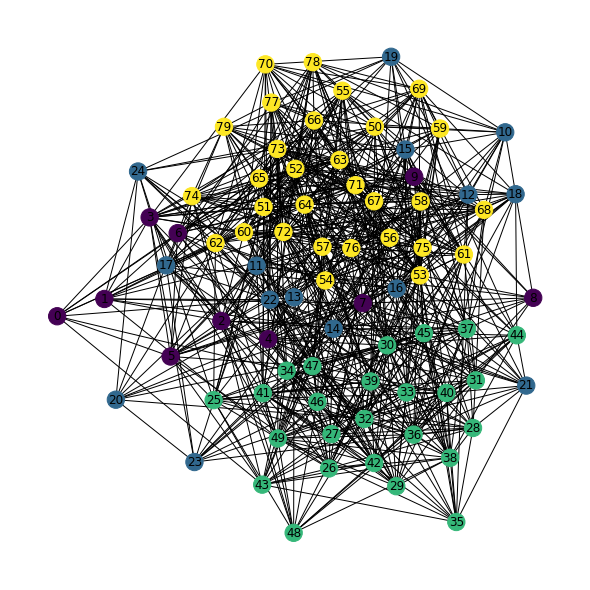

In [ ]:
pinta_comunidades(G_ejemplo,particion)

###3.2.1 Aplicación y comparación de los metodos para la detección de comunidades. 

A continuación una lista donde enumero los algoritmos para la detección de comunidades que estan implementados en la función `community_structure()`, recibe como entrada un grafo y 1 numeros correspondientes al método, devuele la partición sugerida.
* 1. `community_multilevel() `
* 2. `community_infomap() `
* 3. `community_label_propagation() `
* 4. `community_spinglass() `
* 5. `community_walktrap() `

In [ ]:
#@title community_structure 
def community_structure(grafo, method1):
  #Primero pasamos d eun grafo de networkx a igraph
  graph = ig.Graph.from_networkx(grafo)
  if method1 == 1:
    # Realizar la detección de comunidades del primer método
    c1 = graph.community_multilevel().membership
  elif method1 == 2:
    #community_infomap
    c1 = graph.community_infomap().membership
  elif method1 == 3:
    #community_label_propagation
    c1 = graph.community_label_propagation().membership
  elif method1 == 4:
    #community_spinglass
    c1 = graph.community_spinglass().membership
  else:
    #community_walktrap
    walktrap_dendrogram = graph.community_walktrap()
    c1 = walktrap_dendrogram.as_clustering().membership
  return c1

Uso esta función auxiliar para poder calcular el indice Rand

In [ ]:
def generar_lista_tamanos(conjuntos):
    tamanos = [len(conjunto) for conjunto in conjuntos]
    lista_tamanos = []
    for i, tam in enumerate(tamanos):
        lista_tamanos += [i] * tam
    return lista_tamanos

In [ ]:
particion_original = generar_lista_tamanos(particion)

In [ ]:
c1 = community_structure(G_ejemplo,1)
c2 = community_structure(G_ejemplo,2)
c3 = community_structure(G_ejemplo,3)
c4 = community_structure(G_ejemplo,4)
c5 = community_structure(G_ejemplo,5)

In [ ]:
print("El indice rand entre la partición original y el metodo 1 es: ", adjusted_rand_score(particion_original, c1)) 
print("El indice rand entre la partición original y el metodo 2 es: ", adjusted_rand_score(particion_original, c2)) 
print("El indice rand entre la partición original y el metodo 3 es: ", adjusted_rand_score(particion_original, c3)) 
print("El indice rand entre la partición original y el metodo 4 es: ", adjusted_rand_score(particion_original, c4)) 
print("El indice rand entre la partición original y el metodo 5 es: ", adjusted_rand_score(particion_original, c5)) 

El indice rand entre la partición original y el metodo 1 es:  0.8313771324006848
El indice rand entre la partición original y el metodo 2 es:  0.0
El indice rand entre la partición original y el metodo 3 es:  0.0
El indice rand entre la partición original y el metodo 4 es:  0.8704304610011806
El indice rand entre la partición original y el metodo 5 es:  0.8172942456712678


Veamos un ejemplo de un método que fue muy bueno.

community_spinglass, con el cual se obtuvo un indice Rand de 0.87


In [ ]:
g = ig.Graph.from_networkx(G_ejemplo)
spinglass = g.community_spinglass()

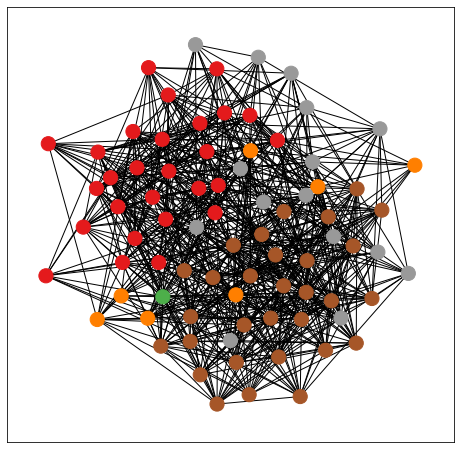

In [ ]:
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G_ejemplo, seed=2023)

nx.draw_networkx_nodes(G_ejemplo, pos, node_size=200, cmap=plt.cm.Set1, node_color=spinglass.membership)
nx.draw_networkx_edges(G_ejemplo, pos)

plt.show()

###3.3 Adult Dataset

###3.1